# Scanpy: Preprocessing and clustering 3k PBMCs

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

（更新日:2024-2-6 with ShortCake v1.9.1）

Scanpyを用いたクラスタリング解析の基本的なワークフローを紹介します。 Google ColabまたはJupyter notebook上で作業を行います。
内容はSeuratの[Guided tutorial](https://singlecellanalysistutorial.readthedocs.io/en/latest/notebooks/GuidedTutorial.html)とほぼ同じですので、そちらもあわせて参考にしてください。

## 前準備

Google Colabで本チュートリアルを実行する場合は まず下記コマンドでScanpyをインストールしてください。

In [ ]:
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain leidenalg scanpy 

### データダウンロード（初回のみ）
Jupyterでは冒頭に ! 記号をつけるとLinuxコマンドを実行することができます。これをマジックコマンドと言います。

- **mkdir**はディレクトリを新規作成するLinuxコマンドです。
- **wget**を使って、今回の解析に用いるデータをWebからダウンロードし、ローカルに保存します。データサイズは7.27Mです。
- **tar**コマンドでダウンロードされた圧縮ファイルを解凍します。

In [1]:
!mkdir -p data write
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2024-02-06 19:27:21--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-02-06 19:27:21--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  18.4MB/s    in 0.4s    

2024-02-06 19:27:21 (18.4 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [118]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import scanpy as sc

# ログなどのパラメータ設定
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'write/pbmc3k.h5ad' # 出力ファイル名

入力データ（10X CellRangerで生成されたディレクトリ）を読み込み、[AnnDataオブジェクト](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) に格納

In [119]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # 入力ディレクトリ
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # 計算の高速化のためにキャッシュを利用する

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

2700細胞 x 32738遺伝子のAnnDataが作成されました。

## Preprocessing
各細胞の全リードに対して占める割合が最も高い遺伝子を表示します。

normalizing counts per cell
    finished (0:00:00)


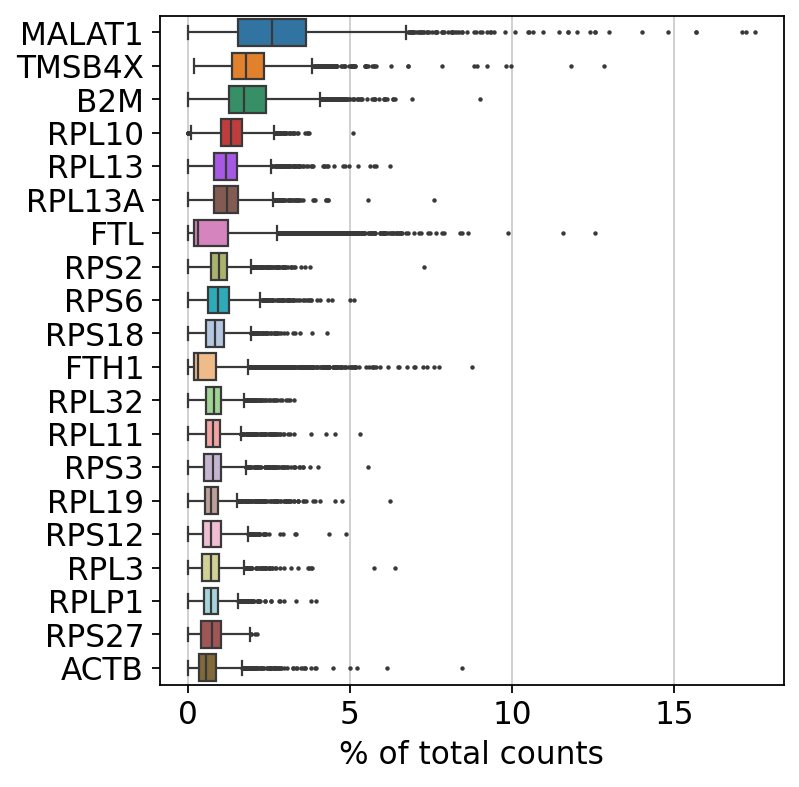

In [120]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### フィルタリング

発現遺伝子数が200未満の細胞、発現細胞数が3未満の遺伝子をフィルタします。

In [121]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


発現細胞数が3未満の19,024遺伝子がフィルタされ、2700細胞 x 13714遺伝子のAnnDataになりました。

In [122]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

次に、品質評価に重要なミトコンドリア遺伝子の発現量を計測します。
ミトコンドリアの発現割合が高い細胞は死細胞とみなされます。 [ (Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics)

`pp.calculate_qc_metrics` 関数によって多数の品質評価指標を取得できます。

In [123]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

violin plotで以下の尺度を評価します。
- カウントマトリックス中の発現遺伝子数
- 細胞あたりの総カウント数
- ミトコンドリア遺伝子におけるカウントの割合

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


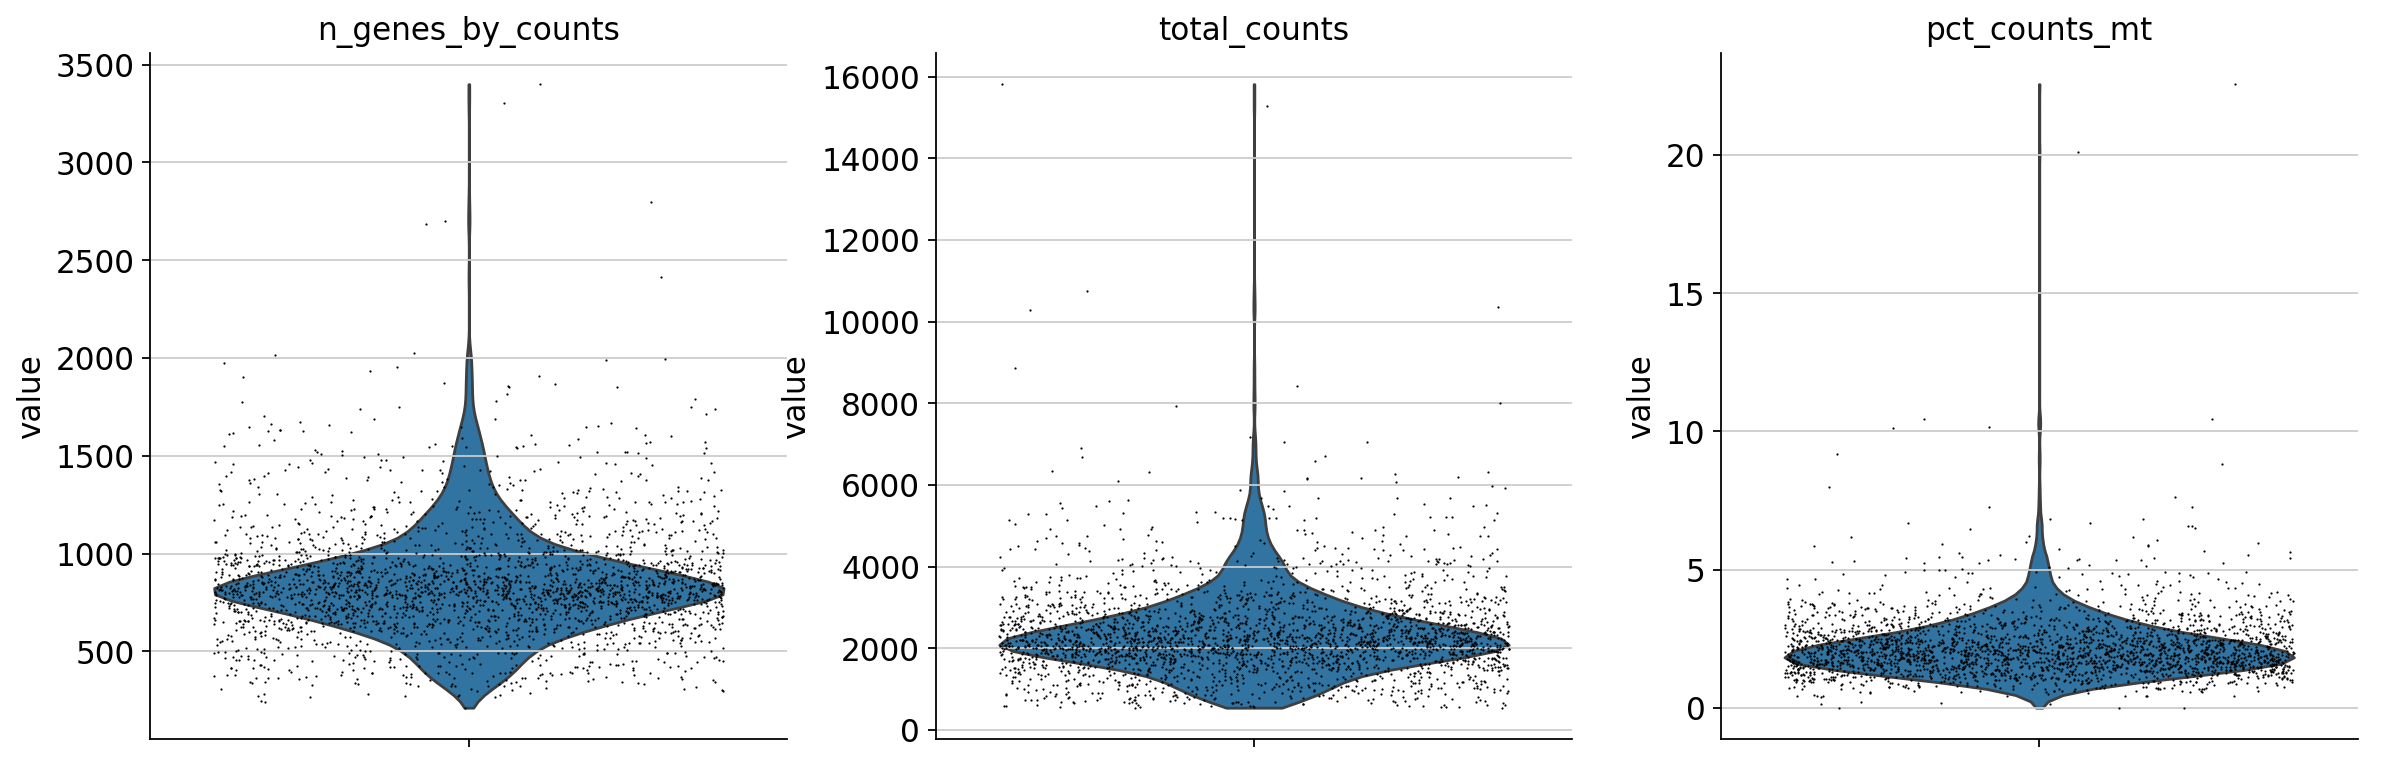

In [124]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

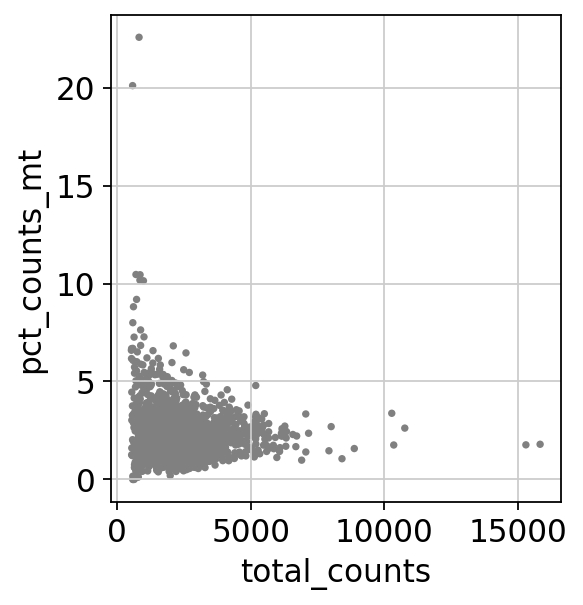

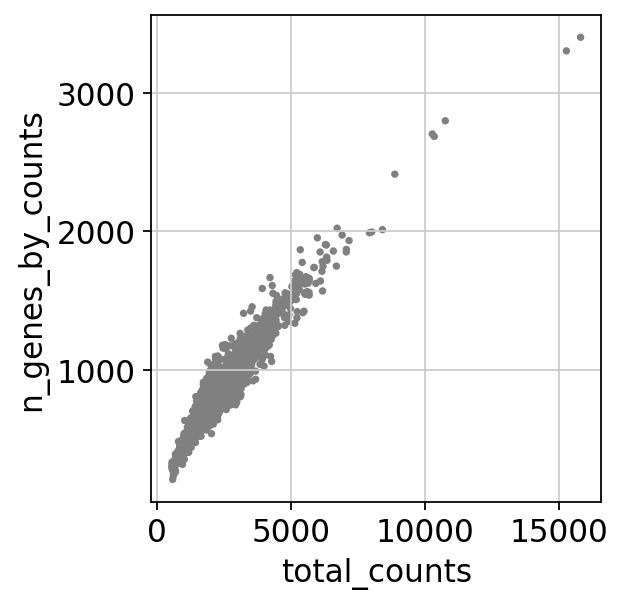

In [125]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

ミトコンドリア由来の遺伝子が多すぎる細胞(5%以上)、またはtotal countsの値が多すぎる細胞(2500以上)を削除します。

In [126]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

2638細胞 x 13714遺伝子のAnnDataになりました。

## 正規化

In [127]:
# Total read countを10000に正規化
sc.pp.normalize_total(adata, target_sum=1e4)

# 対数変換
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## highly-variable genesを検出

In [128]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### highly-variable genesのプロット

（左が正規化後、右が正規化前の発現量(Y軸)）

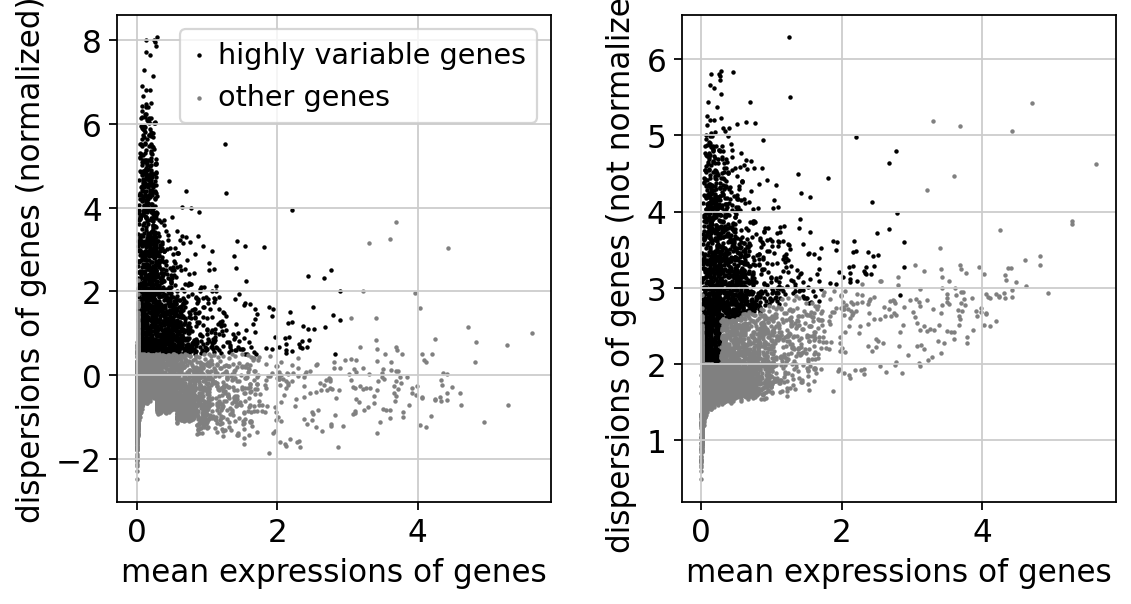

In [129]:
sc.pl.highly_variable_genes(adata)

正規化・対数化後の遺伝子発現データをrawdataとして AnnDataオブジェクトの`.raw` に格納します。

（`sc.pp.regress_out` を用いたデータ補正と `sc.pp.scale` を使ったスケーリングを以下で行わない場合は`.raw`は必要ありません。）

In [130]:
adata.raw = adata

以下のコマンドはadataをhighly-variable genesのみに抽出する操作だが、highly-variable genesのリストは `.var.highly_variable` に保存され、PCAやその後に続く解析では自動的にそれが用いられるため、以下の操作は必要ない。

In [131]:
# adata = adata[:, adata.var.highly_variable]

### スケーリング

細胞あたりのUMI数とミトコンドリア遺伝子の発現率の効果を再調整します。データを単位分散にスケールします。

In [132]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# 標準偏差10を超える値はクリップする
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:01)


## 主成分分析（PCA）

In [133]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


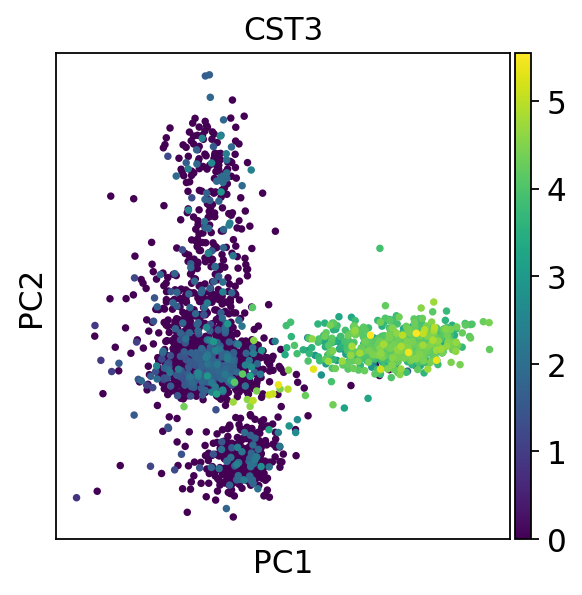

In [134]:
sc.pl.pca(adata, color='CST3')

主成分の寄与率を表示します。以降のtSNEやlouvainクラスタリングで使う主成分数をおおまかに見積もります。

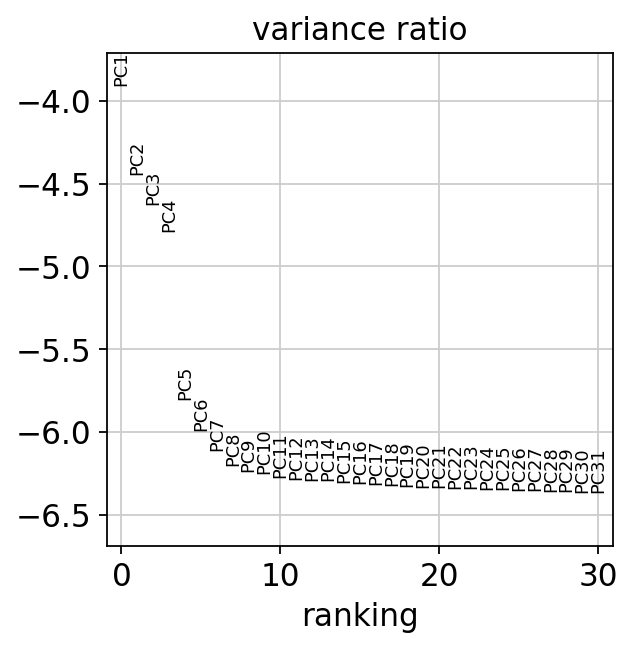

In [135]:
sc.pl.pca_variance_ratio(adata, log=True)

ここまでの結果をresults_fileに出力

In [136]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 近傍グラフの計算

得られたPCAデータを用いて細胞の近傍グラフを計算します。ここではPC40まで使います。

In [137]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


### 近傍グラフへの埋め込み

- UMAPを使って２次元まで次元削減します。これはtSNEよりも多様体のグローバルな接続性に忠実である可能性があります。
- いくつかのケースでは、クラスタが切断されていたり、似たような連結の切断が見られることがあります。そのような場合には、以下のコメントアウトしている関数を実行してください。

In [138]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

In [139]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


### 正規化後の発現量でヒートマップ

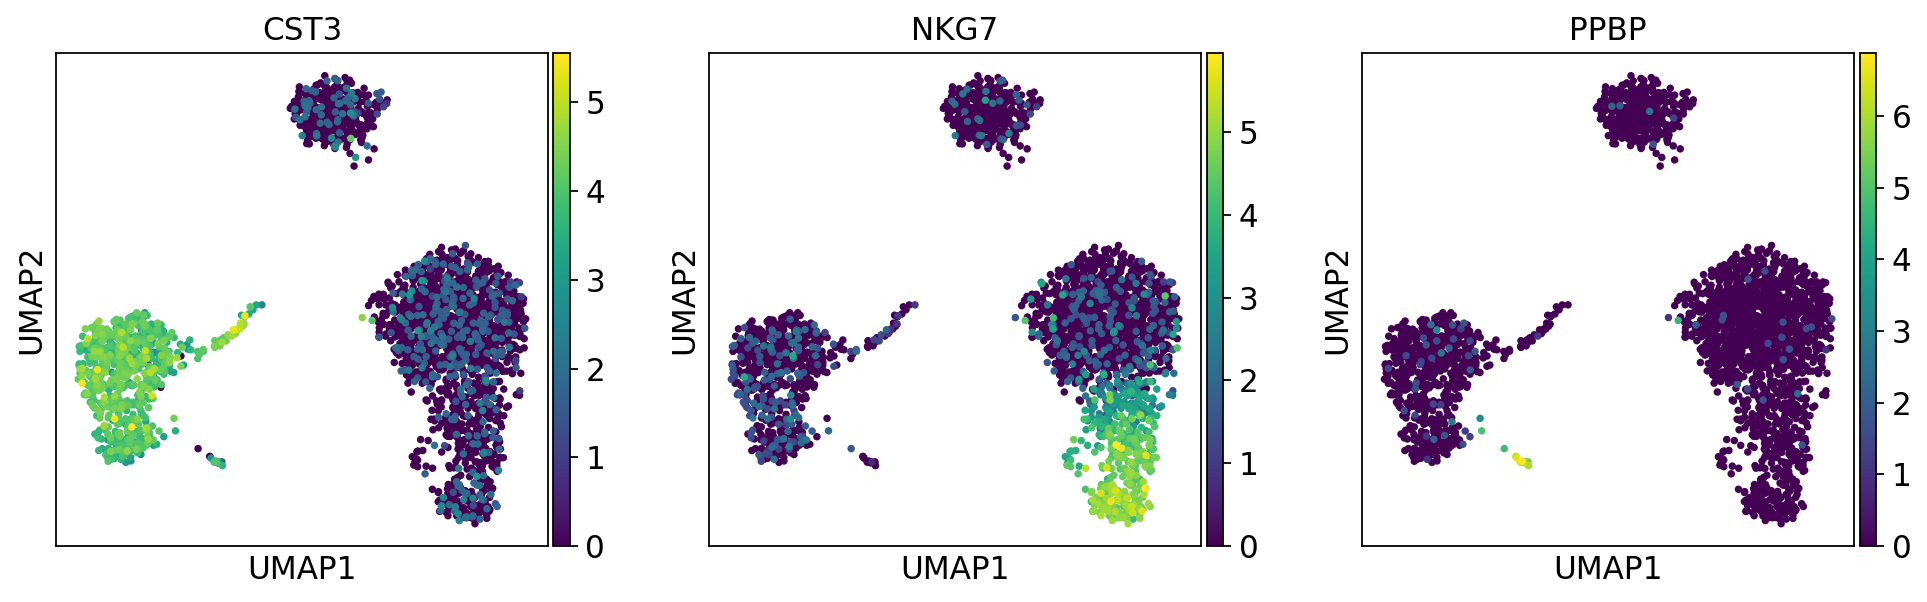

In [140]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

### スケーリングした値（Z値）でヒートマップ

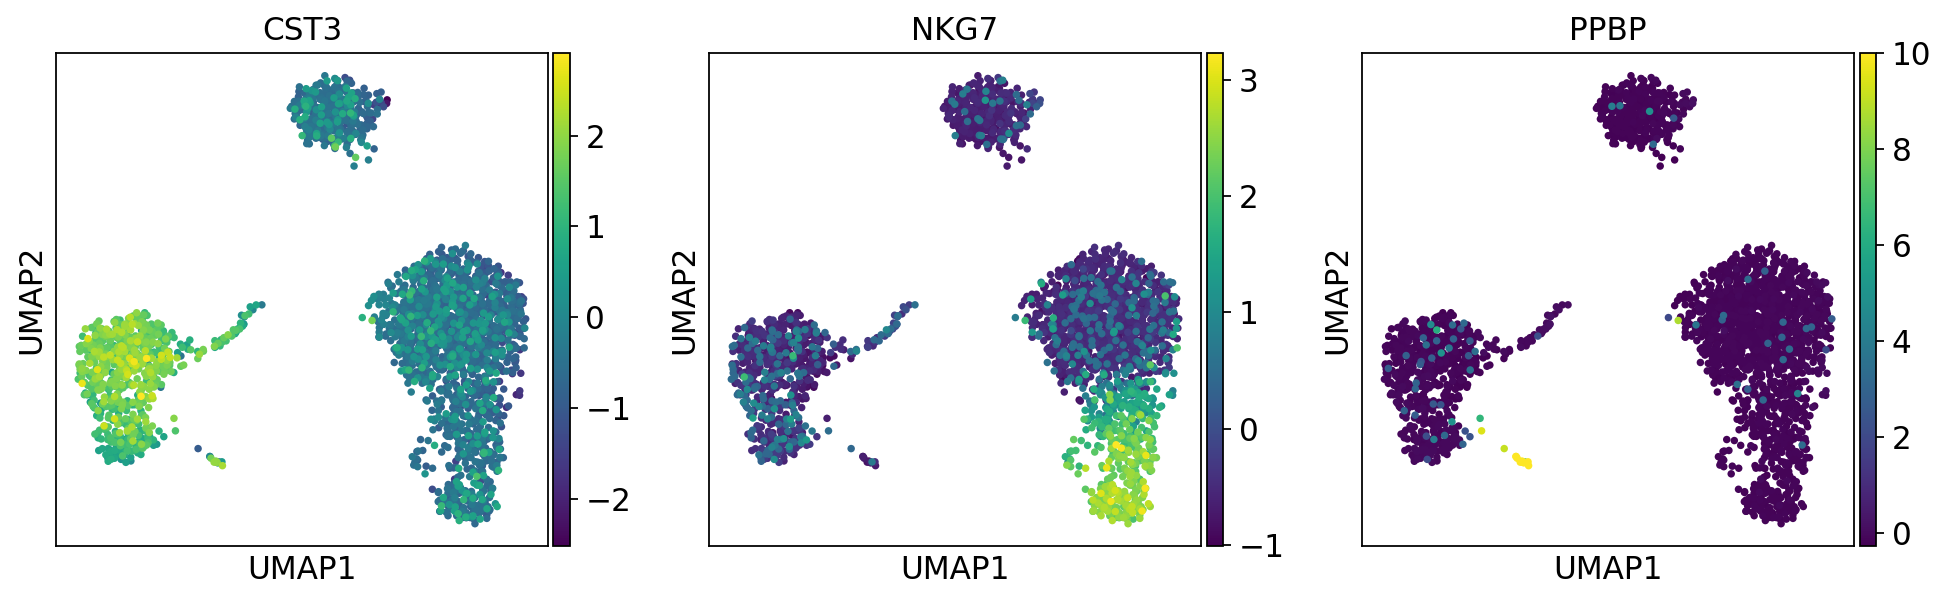

In [141]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering

他のツール群と同様に、Leiden graph-clustering methodを推奨します。
Leiden clusteringは先ほど計算した neighborhood graphを用いてクラスタリングします。

In [142]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


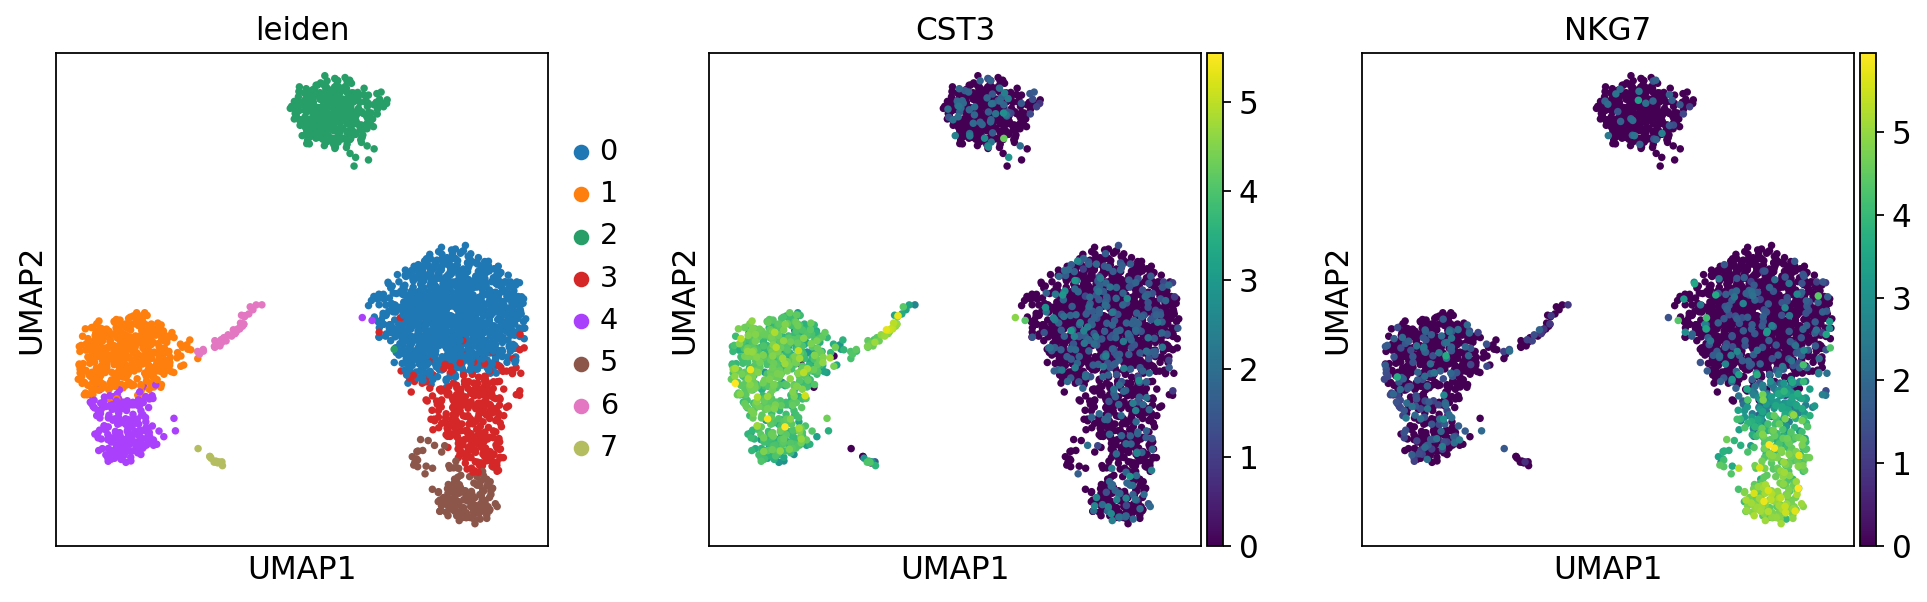

In [143]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [144]:
# データの保存
adata.write(results_file)

## Finding marker genes

各クラスター内の発現変動遺伝子のランキングを計算します。デフォルトでは`AnnData`の.raw属性が使用されます。
発現変動解析のための最も単純で最速の方法はt-検定です。

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


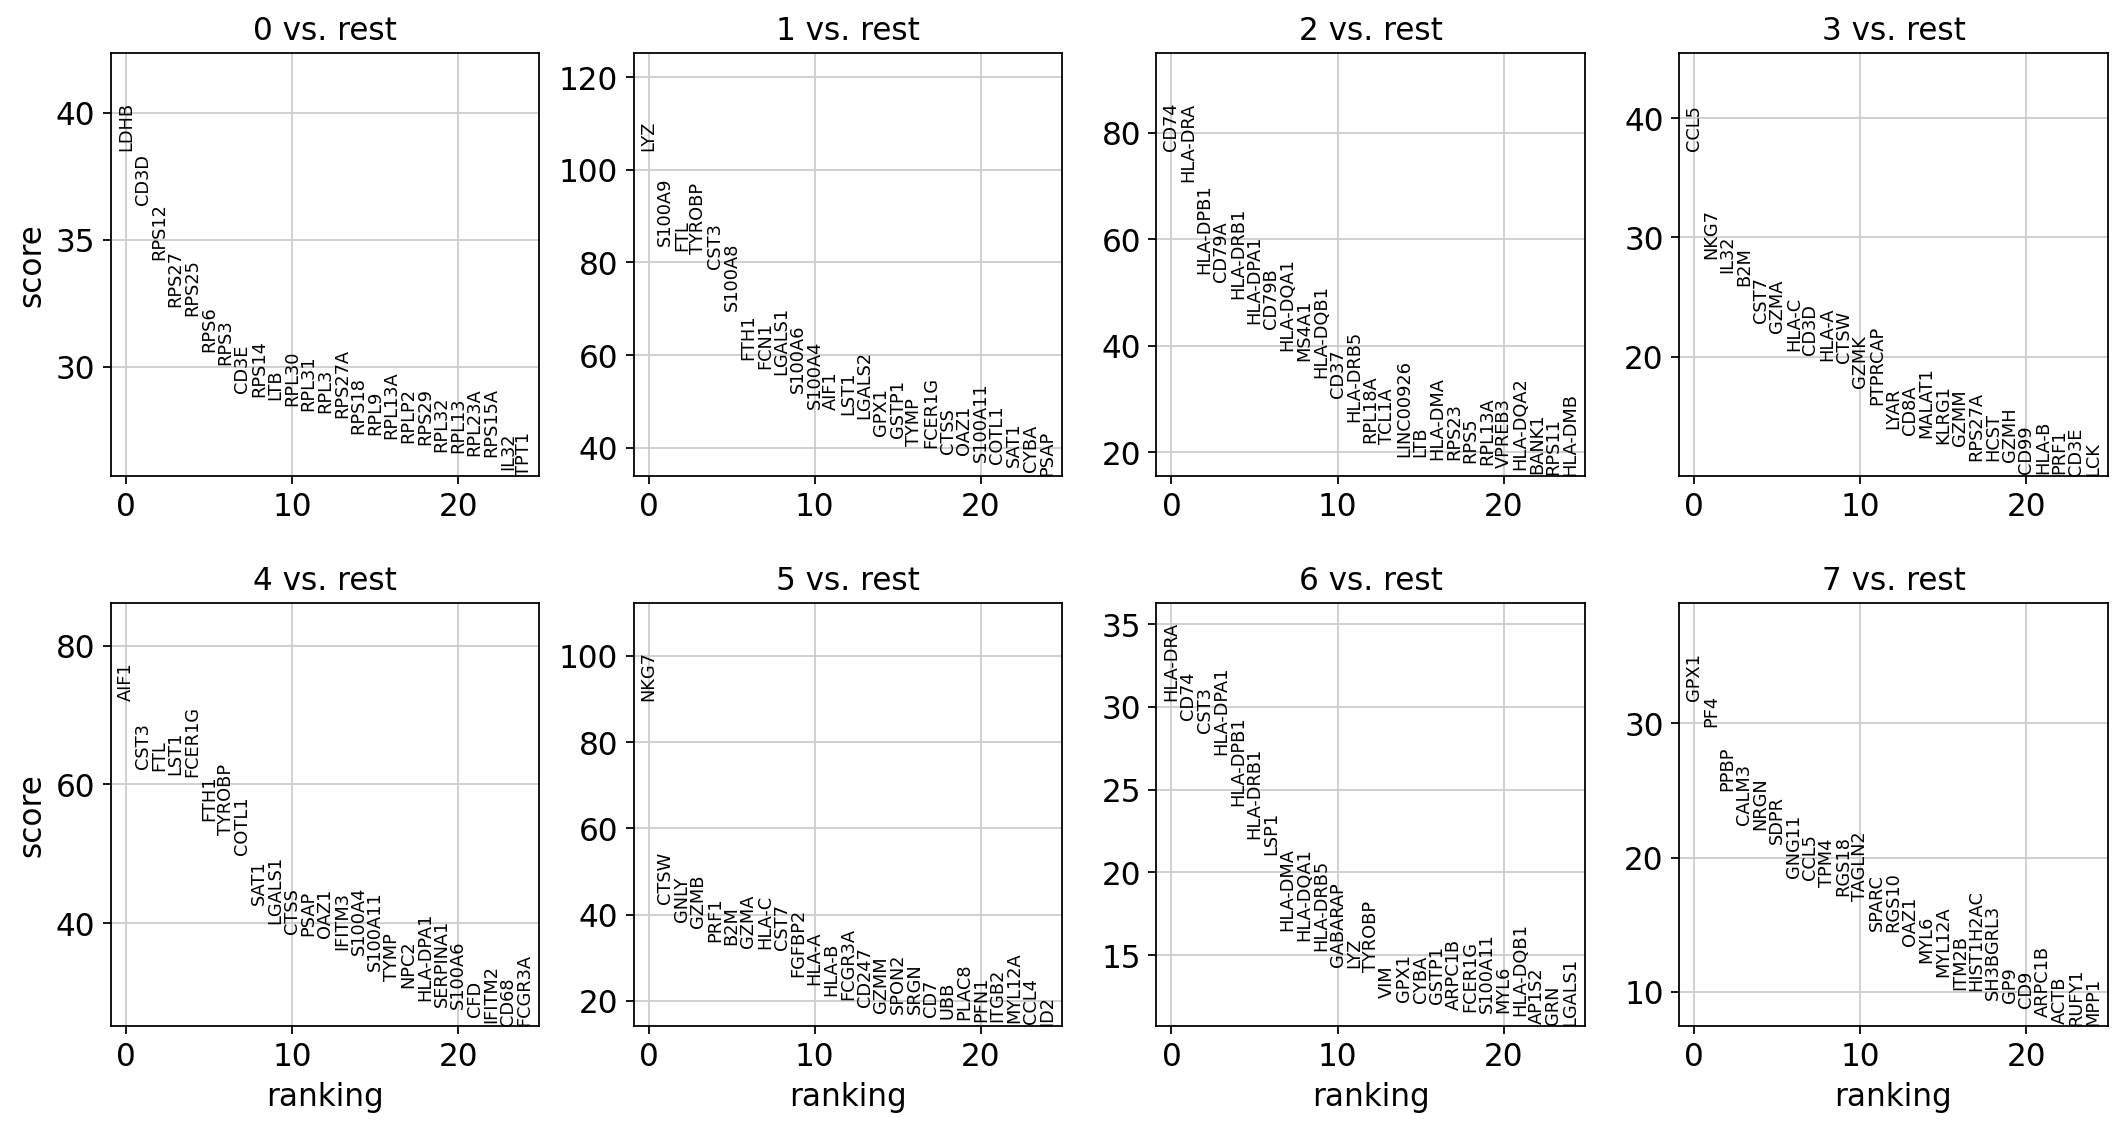

In [145]:
# t-test
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [146]:
sc.settings.verbosity = 2  # reduce the verbosity

- Wilcoxon rank-sum (Mann-Whitney-U) test はt検定と非常に似た結果を返しますが、我々はWilcoxon testを推奨します (see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612)). 
- 更に強力な他の手法もあります（例： MAST, limma, DESeq2 and, for python, the recent diffxpy）

ranking genes
    finished (0:00:01)


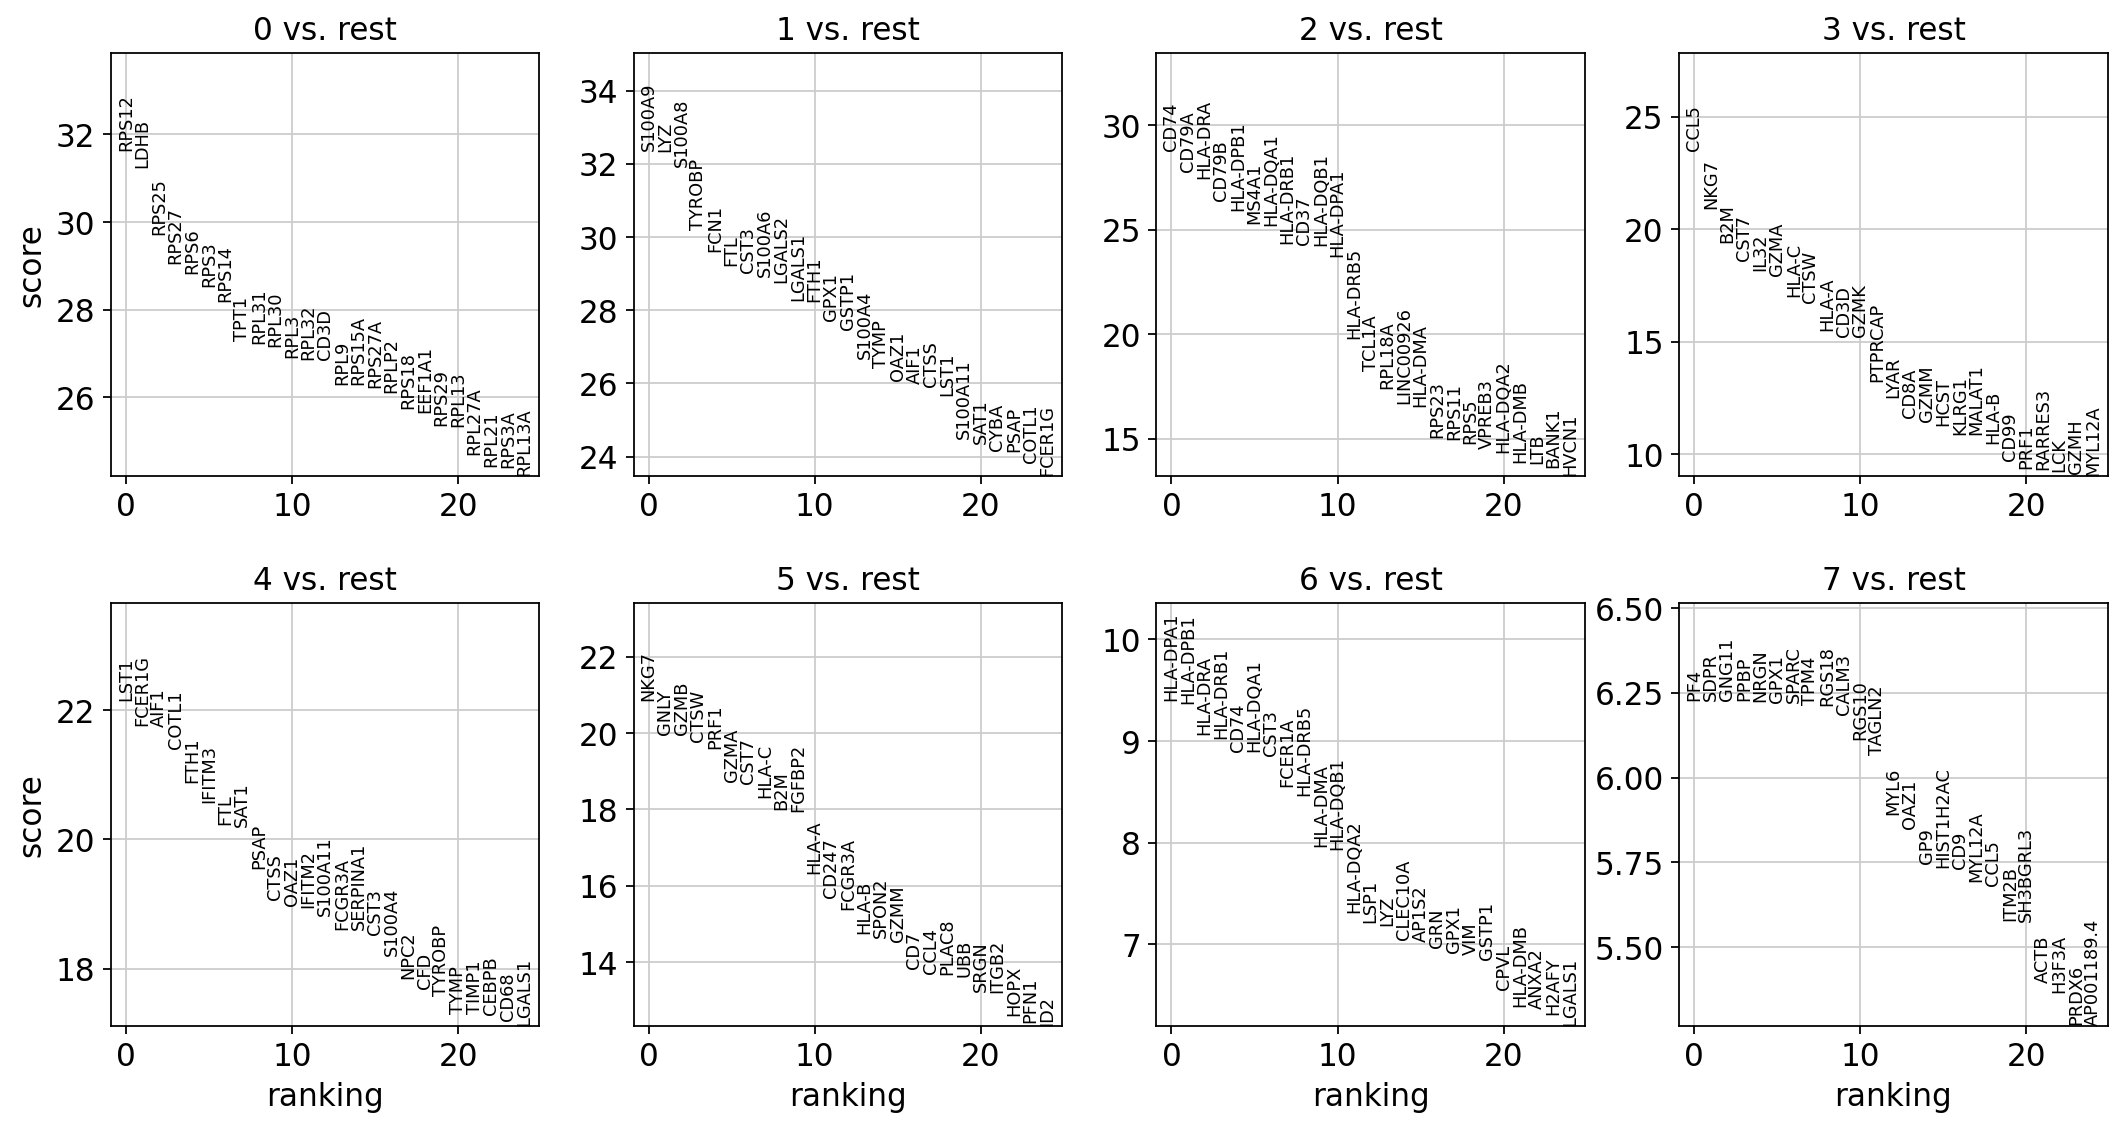

In [147]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [148]:
# データの保存
adata.write(results_file)

- 他の手法として、ロジスティック回帰を用いて遺伝子をランク付けしてみましょう ([Natranos et al. (2018)](https://doi.org/10.1101/258566))。本質的な違いは、従来の微分検定が一変量であるのに対し、ここでは多変量のアプローチを使用していることです([Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79))。

ranking genes
    finished (0:00:04)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


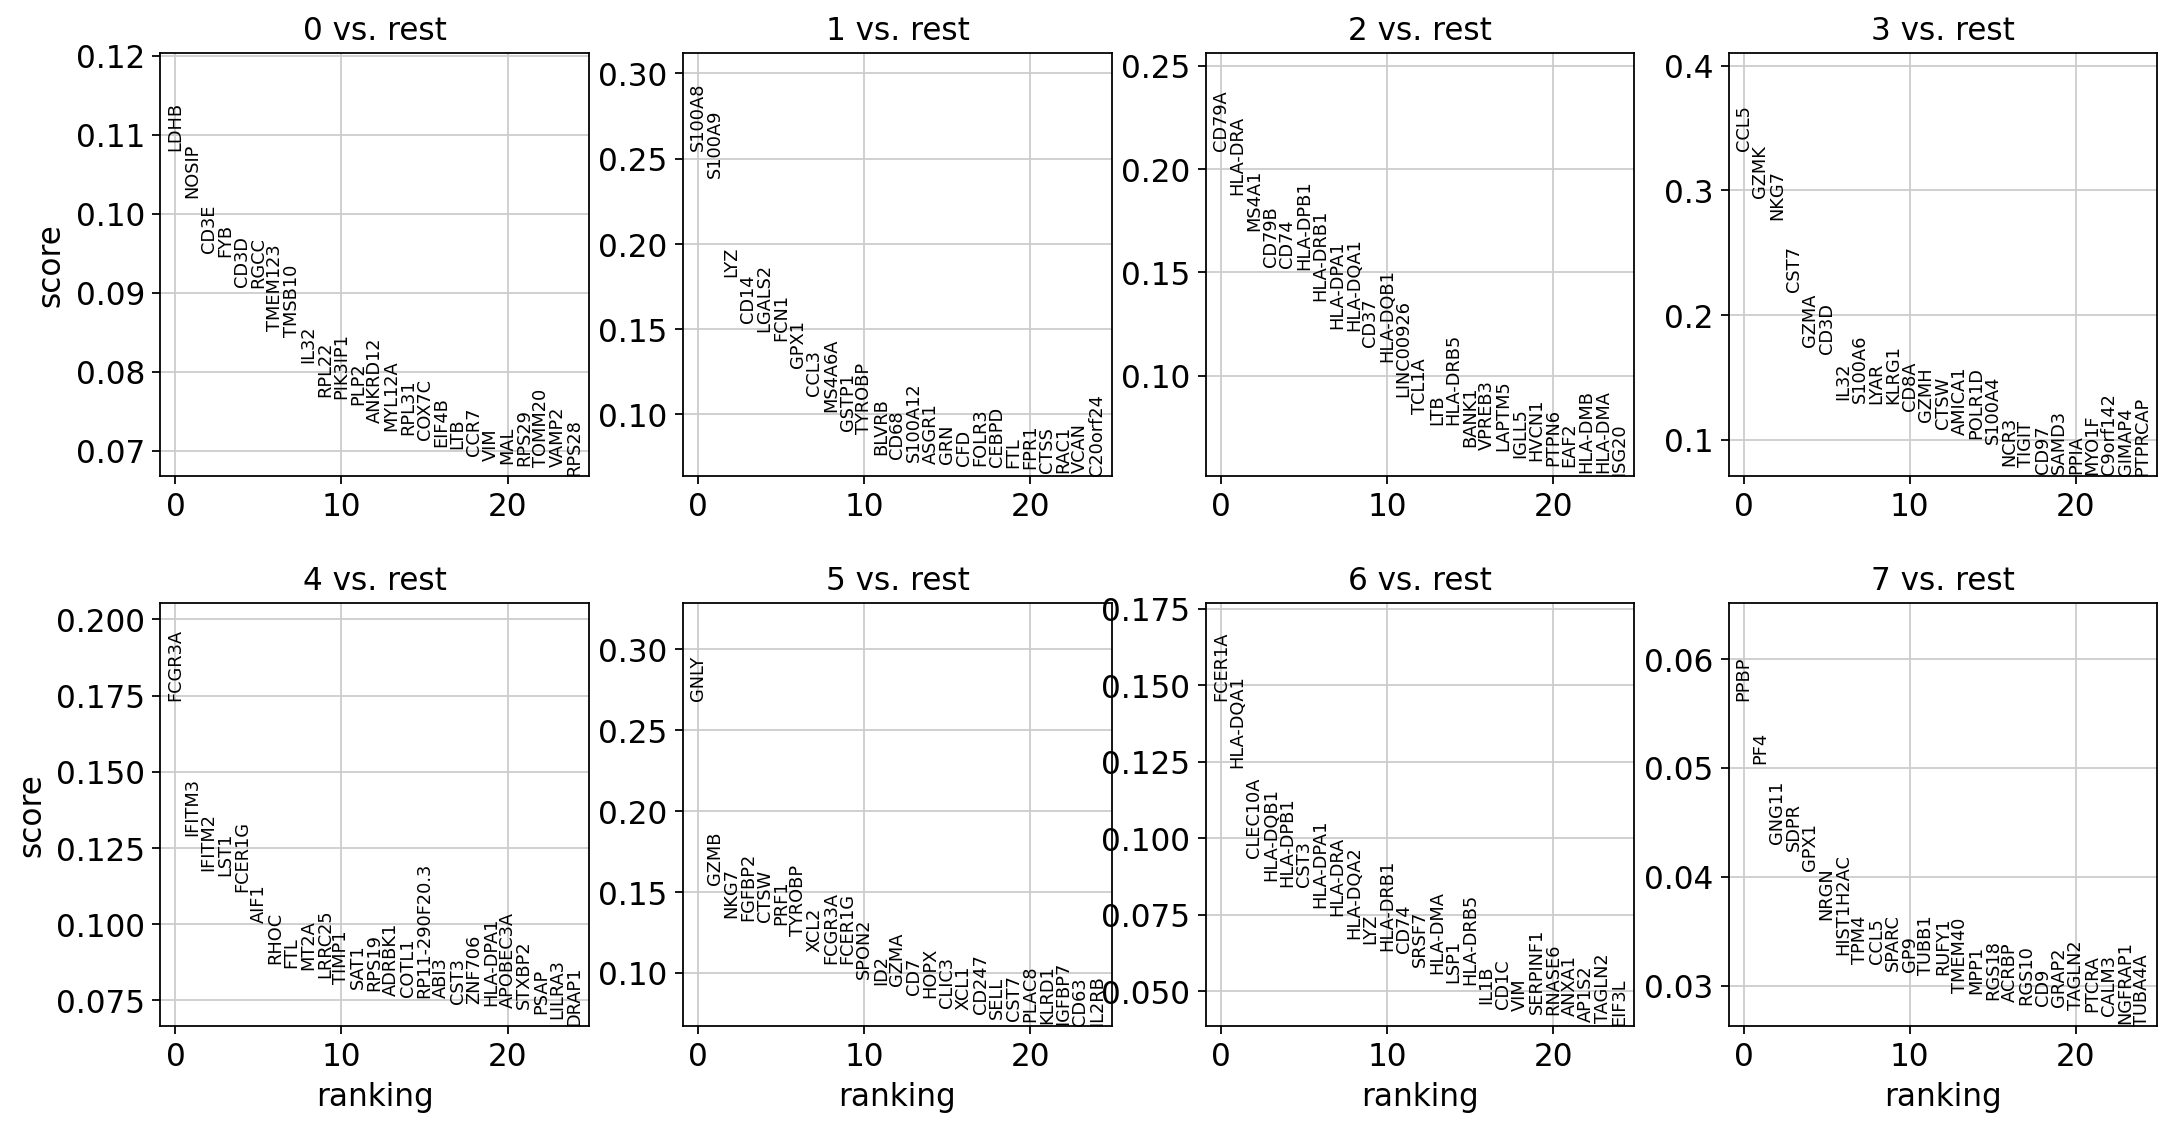

In [149]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

t検定でしか見つからないIL7Rと、他の2つの評価法でしか見つからないFCER1Aを除いて、どの手法でも同様のマーカーを特定できました。

In [150]:
# 得られたマーカー遺伝子をリスト化
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [151]:
# Wilcoxonを用いてやりなおし
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

ranking genes
    finished (0:00:02)


0       1         2     3       4     5         6      7
0  RPS12  S100A9      CD74  CCL5    LST1  NKG7  HLA-DPA1    PF4
1   LDHB     LYZ     CD79A  NKG7  FCER1G  GNLY  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M    AIF1  GZMB   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7   COTL1  CTSW  HLA-DRB1   PPBP
4   RPS6    FCN1  HLA-DPB1  IL32    FTH1  PRF1      CD74   NRGN

In [152]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  1.402350e-219  S100A9  7.401057e-230      CD74  3.043536e-182  CCL5   
1   LDHB  2.805350e-214     LYZ  2.067780e-229     CD79A  6.860832e-170  NKG7   
2  RPS25  4.562865e-194  S100A8  9.925222e-224   HLA-DRA  8.389292e-166   B2M   
3  RPS27  1.164214e-185  TYROBP  1.541222e-200     CD79B  1.171444e-153  CST7   
4   RPS6  8.893675e-183    FCN1  9.951201e-193  HLA-DPB1  6.167786e-148  IL32   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  3.380869e-122    LST1  9.584233e-109  NKG7  1.203971e-96  HLA-DPA1   
1   4.248878e-97  FCER1G  4.998734e-105  GNLY  1.257170e-88  HLA-DPB1   
2   5.445592e-84    AIF1  6.891419e-105  GZMB  1.429027e-88   HLA-DRA   
3   1.850639e-77   COTL1  1.329234e-101  CTSW  4.144726e-87  HLA-DRB1   
4   7.057861e-74    FTH1   8.135658e-97  PRF1  1.692100e-85      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

### クラスター０と１を比較

ranking genes
    finished (0:00:00)


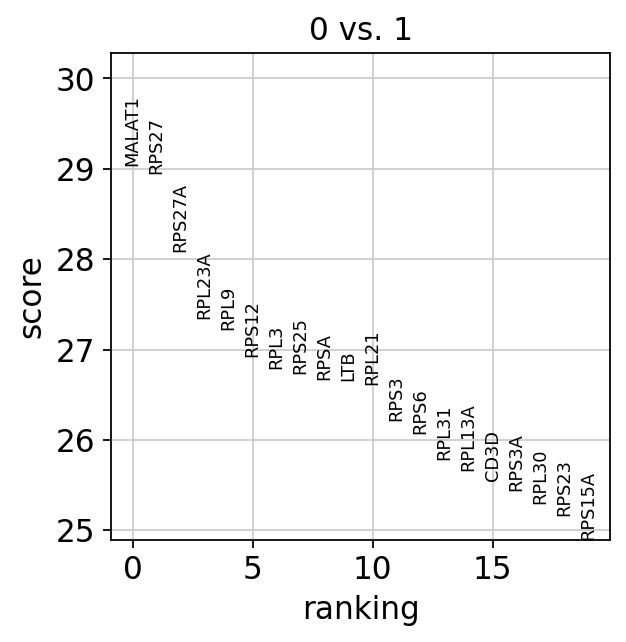

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


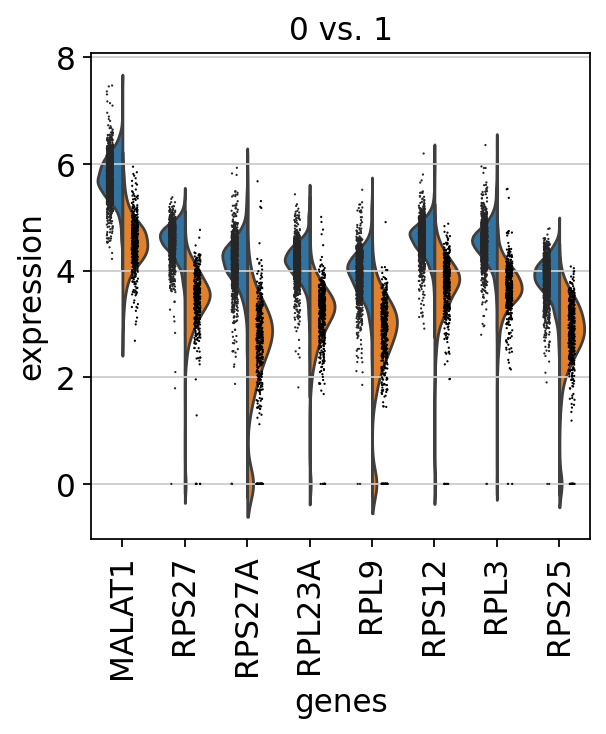

In [153]:
# DEGランキング
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

#発現量のviolin plot
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

### 1対他クラスターの比較

ranking genes
    finished (0:00:02)


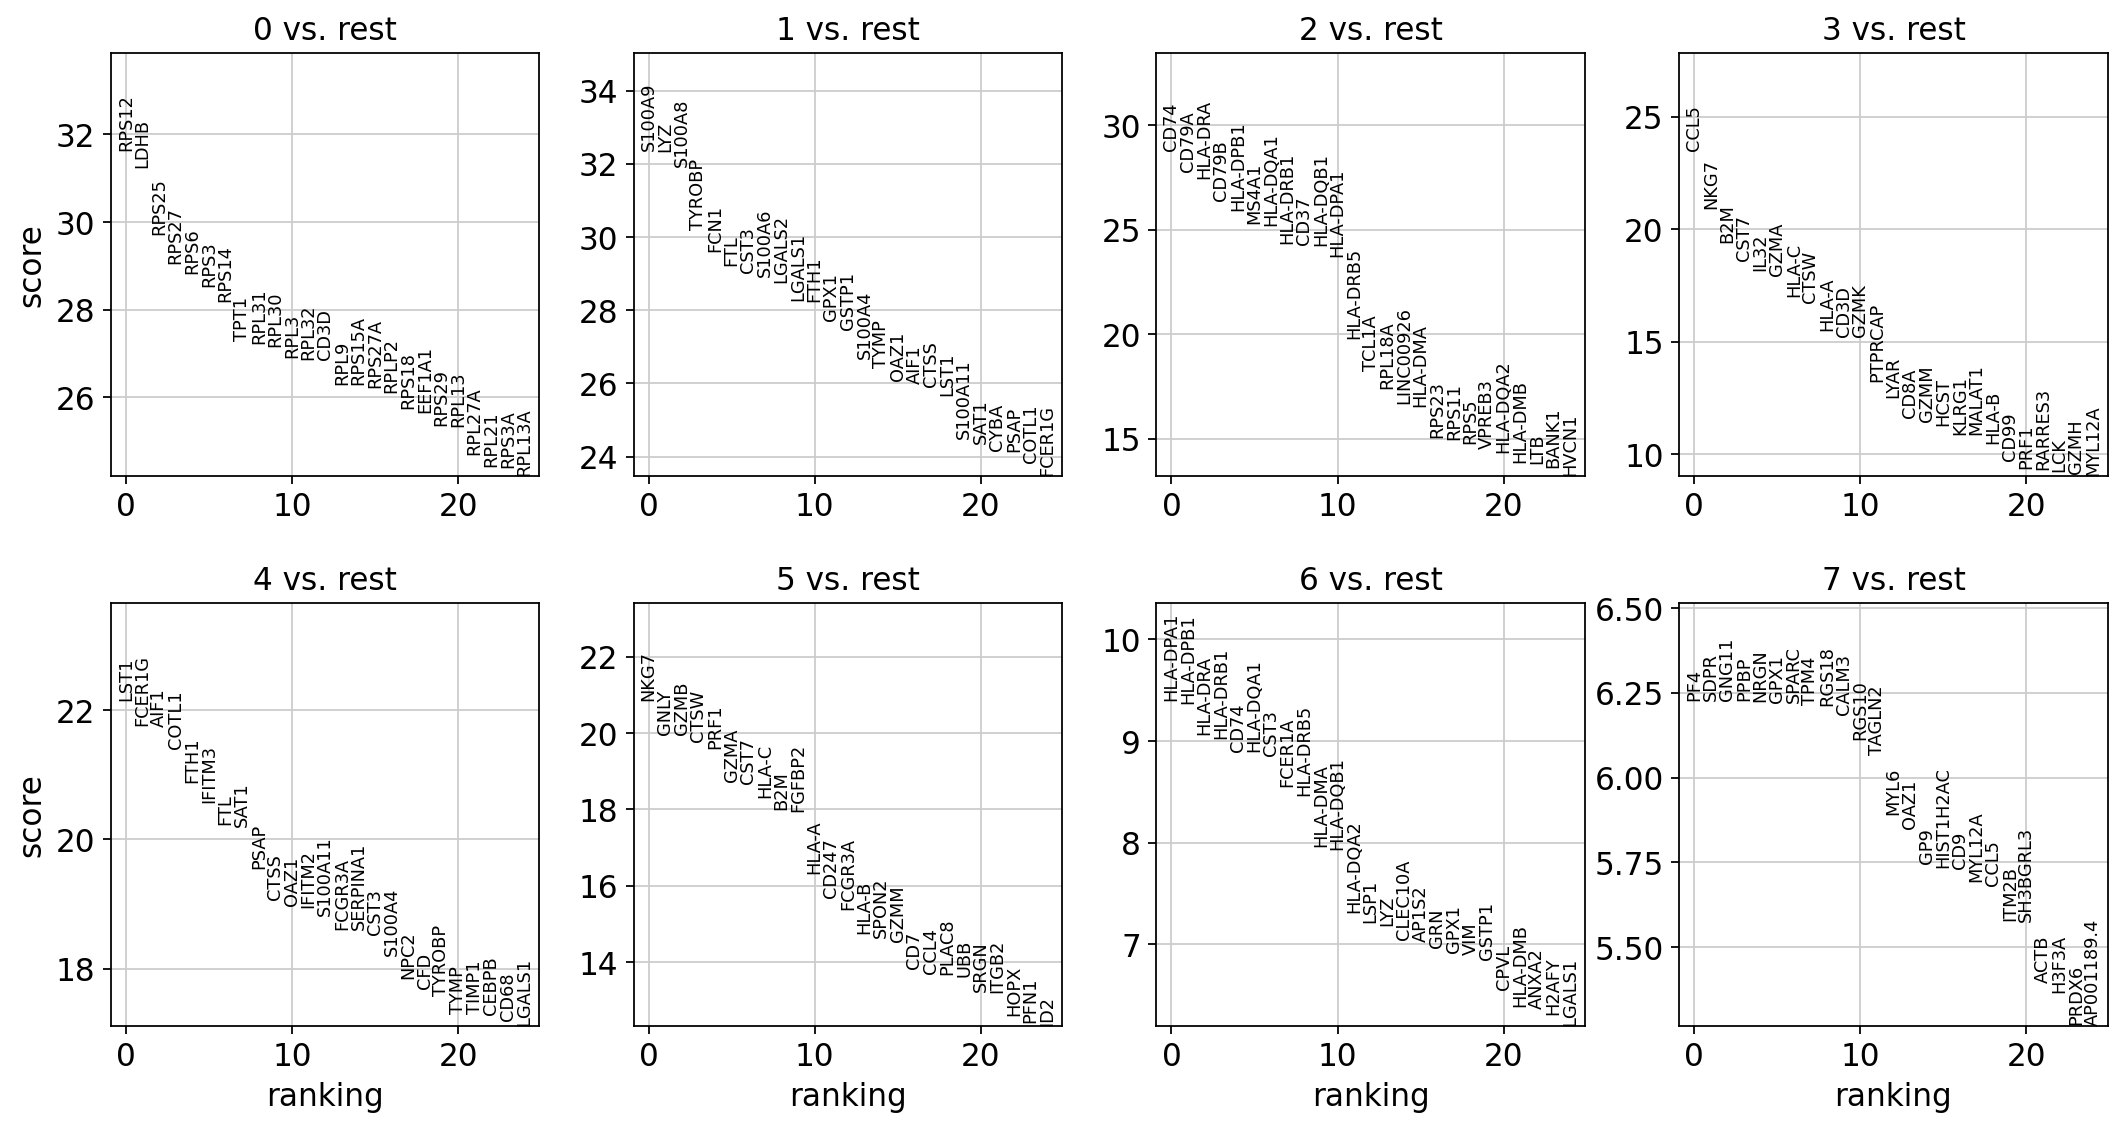

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


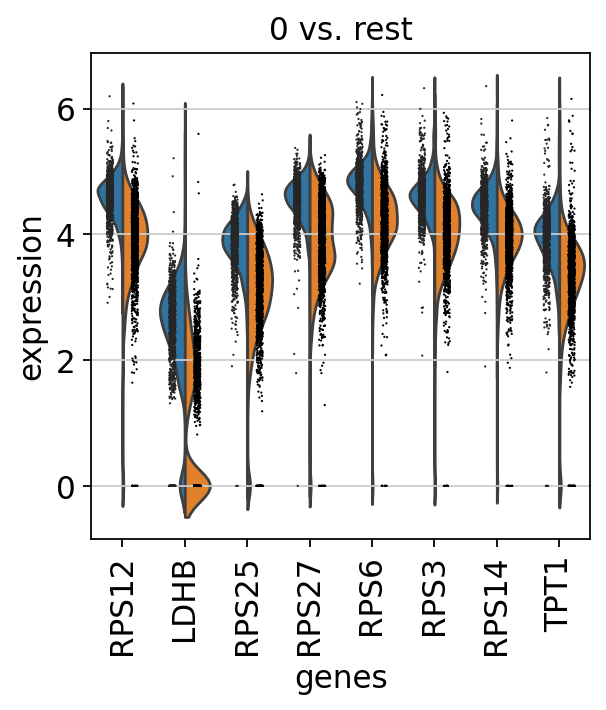

In [154]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been 

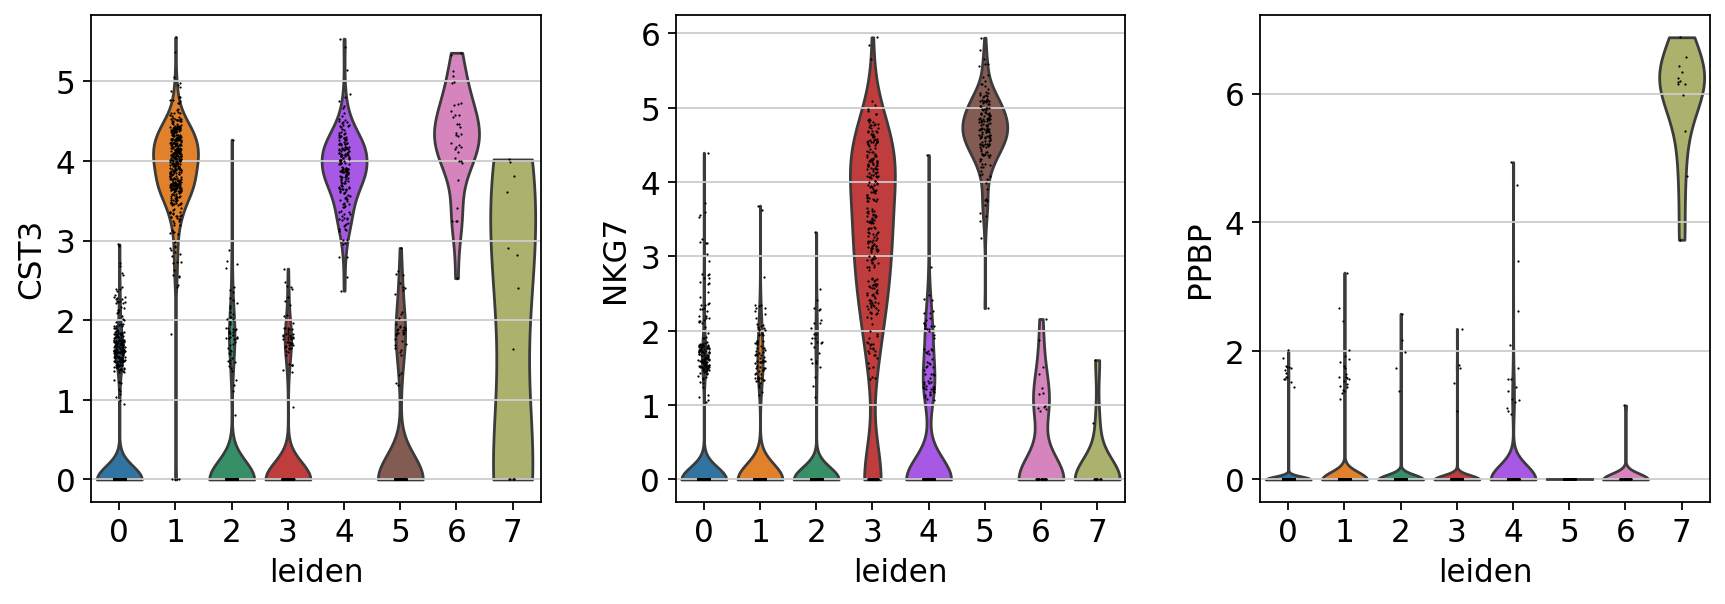

In [155]:
# 指定した遺伝子のクラスター間発現量比較
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

### クラスターにラベルを付与

In [156]:
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes']
#adata.rename_categories('leiden', new_cluster_names) エラーが出るため暫定的に以下のようにする
adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories(new_cluster_names)

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


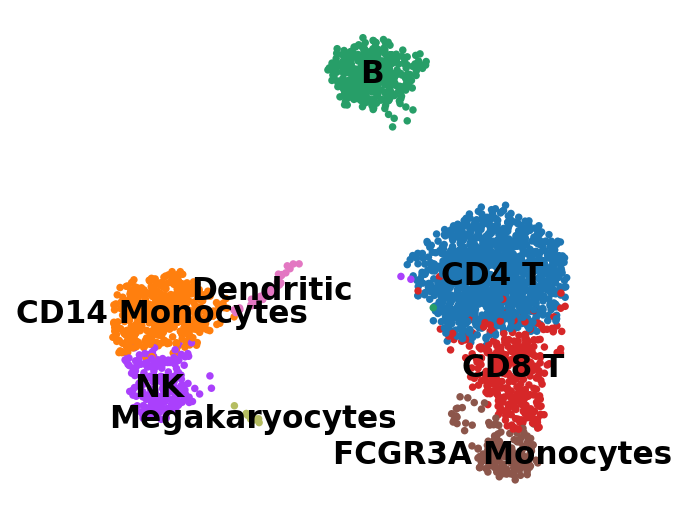

In [157]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

`marker_genes` を使ってマーカー遺伝子の発現量ヒートマップ

（作成者注：上のviolin plotでは分布がわかるが数遺伝子しか可視化できないのに対し、下のヒートマップでは平均値のみの表示だが多数の遺伝子を同時表示可能。）

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


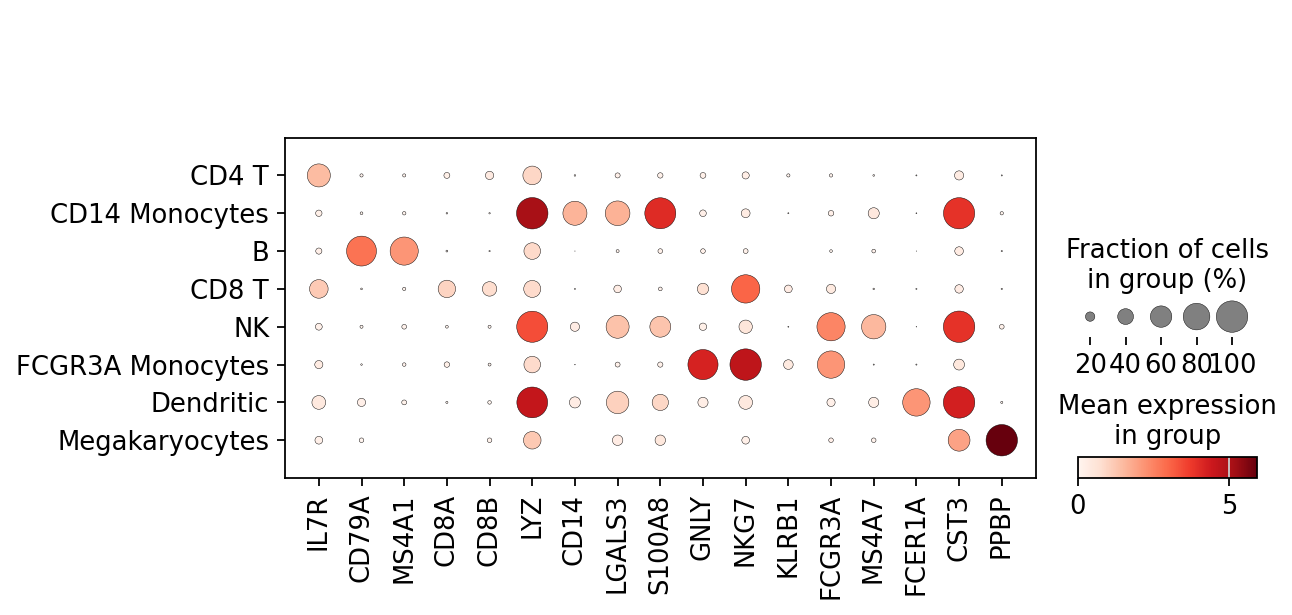

In [158]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

violin plotにすることも可能

（作成者注：busyなのであまりおすすめしない）

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning 

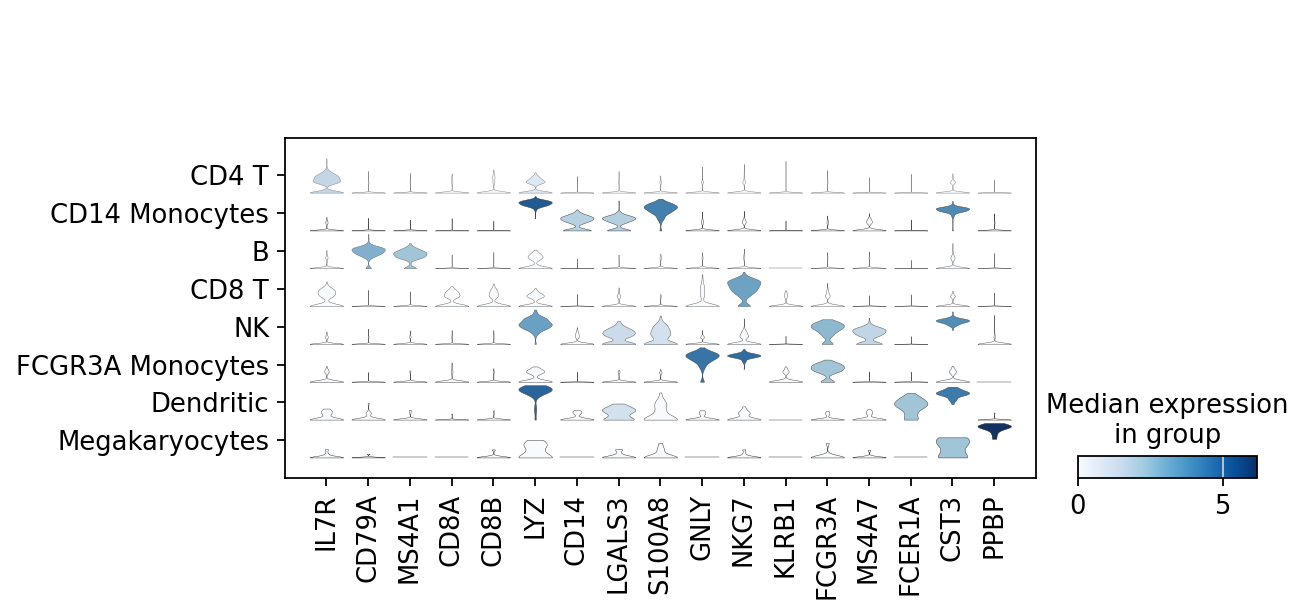

In [159]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden') # , rotation=90

この分析の中で取得されたアノテーションを表示

In [160]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

`compression='gzip'` で圧縮形式でオブジェクト保存

In [161]:
adata.write(results_file, compression='gzip')

- 保存した`.h5ad`ファイルは、[h5lsコマンド](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md) を使ってファイルの大まかな概要を知ることができます 
- このファイルフォーマットは将来的にさらに最適化される可能性がありますが、すべての読み込み機能は後方互換性があります。

In [162]:
!h5ls ./write/pbmc3k.h5ad

X                        Dataset {2638, 13714}
layers                   Group
obs                      Group
obsm                     Group
obsp                     Group
raw                      Group
uns                      Group
var                      Group
varm                     Group
varp                     Group


- このオブジェクトを単に可視化のために使いたい人と共有したい場合、ファイルサイズを小さくする簡単な方法は、スケーリング/補正された発現行列を削除することです。
- 下記コマンドで`adata.raw`に保存された raw dataを保存することができます。

In [163]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

csv形式で保存したい場合は以下のようにします：

In [164]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

In [165]:
import session_info
session_info.show()